The way Emily gets this to work is:

In the bash console, type `\ArcGIS\Pro\bin\Python\Scripts\proenv` to activate the ArcGIS Pro Python 3 conda environment. This is the only way I know to access ArcPy outside of an ArcGIS GUI. Change directories into the location of this code: `cd Code\beachplant_dataextraction` Then open a jupyter lab session: `jupyter lab`. At the beginning, you may need to install some additional Python packages, such as jupyterlab (`conda install -c conda-forge jupyterlab`). 

## First, import the necessary modules

In [250]:
import os
import arcpy
import time
import pandas as pd
import sys
import numpy as np
import pyproj

# Set up alert sound for long-running cells
from IPython.display import Audio
sound_file = r'\\Mac\stor\Code\van-sliding-door-daniel_simon.wav'
from IPython.display import Image

print("Date: {}".format(datetime.date.today()))
print('pandas version: {}'.format(pd.__version__))
print('numpy version: {}'.format(np.__version__))
print('pyproj version: {}'.format(pyproj.__version__))

Date: 2019-07-17
pandas version: 0.20.1
numpy version: 1.11.2
pyproj version: 1.9.5.1


## Set up arcpy environments

In [196]:
# Set year of analysis
year = 2008

# Paths
home = r'\\Mac\stor\Projects\SA_DataProcessing\GDBs'
data_dir = r'\\Mac\stor\Projects\SA_DataProcessing\input_data'

# Set up workspace
yeargdb = os.path.join(home, str(year) +'.gdb')
if not os.path.exists(yeargdb):
    arcpy.CreateFileGDB_management(home, str(year))
    print('Created new gdb "{}.gdb"'.format(year))
arcpy.env.workspace = yeargdb
arcpy.env.scratchWorkspace = home
arcpy.env.overwriteOutput = True 
arcpy.CheckOutExtension("Spatial")

'CheckedOut'

## Initialize filenames and other variables

In [197]:
# Files
DEM_dir = os.path.join(data_dir, 'ASIS_Lidar2008')
DEM = os.path.join(arcpy.env.workspace, 'DEM08')
DEM = 'DEM08'
veg_polyshp = os.path.join(data_dir, 'ASIS_veghabMaps', 'asis_pipl_habitat2008.shp')

# Parameters
year = 2008
MHW = 0.34
MLW = -0.13
MTL = (MHW + MLW)/2
gridsz = 5
plants_epsg = 26918
fill = -99999
ranPts_per_PlantPt = 3
dem_null = -32767
dune_dist_threshold = 300

# Initialize
crs = arcpy.SpatialReference(plants_epsg)
arcpy.env.outputCoordinateSystem = crs

# Output filenames
inletLines = 'inletLines'
SLpts = os.path.join(yeargdb, 'SLpts')
DLpts = os.path.join(yeargdb, 'DLpts')
DHpts = os.path.join(yeargdb, 'DHpts')
barrierBoundary = 'bndpoly08_toSL'
plants_outfc = 'pts_plants'
ranPts = 'pts_random'
trainingPts = 'pts_training'
DEMres = '{}_{}m'.format(DEM, gridsz)
veg_fc = 'asis_pipl_habitat2008'
vegRaster = 'asis_pipl_habitat2008_rst'

## Pre-process: DEM

In [22]:
# Merge DEM tiles
arcpy.env.workspace = DEM_dir
DEMtiles = arcpy.ListRasters("*","TIF")

tile0 = arcpy.Describe(DEMtiles[0])
tile0.bandCount
tile0.spatialReference
arcpy.GetRasterProperties_management(DEMtiles[0], 'VALUETYPE')
arcpy.GetRasterProperties_management(DEMtiles[0], 'CELLSIZEX')

# Reset workspace
DEM = os.path.join(yeargdb, DEM)
arcpy.CopyRaster_management(DEMtiles[0], DEM)

<Result '\\\\Mac\\stor\\Projects\\SA_DataProcessing\\GDBs\\2008.gdb\\DEM08'>

In [23]:
arcpy.Mosaic_management(DEMtiles, DEM, mosaic_type='LAST', nodata_value=dem_null)

<Result '\\\\Mac\\stor\\Projects\\SA_DataProcessing\\GDBs\\2008.gdb\\DEM08'>

In [ ]:
demOut = arcpy.sa.SetNull(DEM, DEM, "VALUE = {}".format(dem_null))
demOut.save(DEM+'_SetNull')

In [ ]:
# Look at environment variables
environments = arcpy.ListEnvironments()
environments.sort(key=str.lower)
for environment in environments:
    env_value = getattr(arcpy.env, environment)
    print("{0:<30}: {1}".format(environment, env_value))

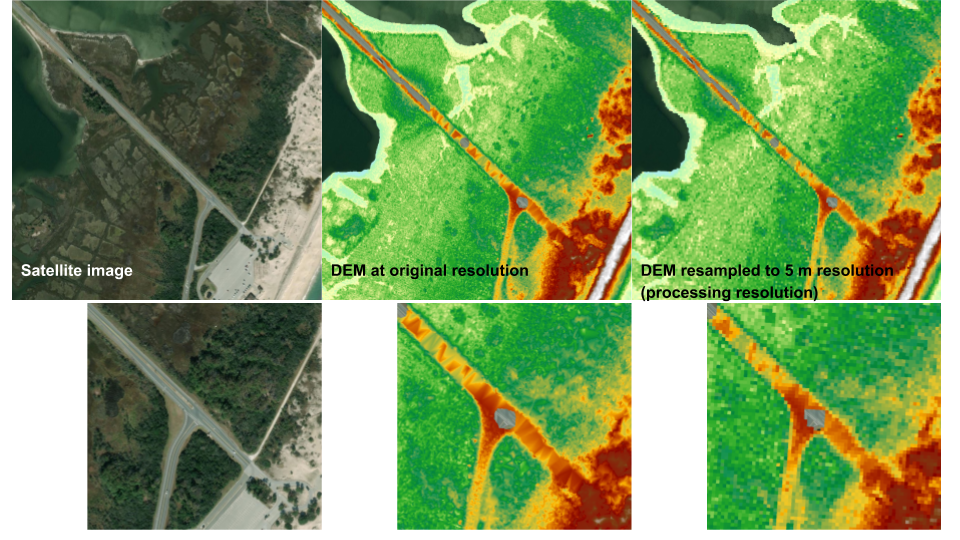

In [249]:
Image("images/DEM_slide.png")